<a href="https://colab.research.google.com/github/fabio-baum/ia_para_engenheiros2/blob/main/Aula_12_Teste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# ============================================================================
# Tree-Based Machine Learning with Hyperparameter Optimization
# Author: Google Colab Assistant
# ============================================================================

# Import necessary libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                            f1_score, accuracy_score, precision_score, recall_score,
                            classification_report, confusion_matrix)

# Tree-based models
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier,
                             GradientBoostingRegressor, GradientBoostingClassifier,
                             ExtraTreesRegressor, ExtraTreesClassifier)
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier

# Progress bars
from tqdm import tqdm
import time

# Set random seed for reproducibility
np.random.seed(42)


In [15]:
# ============================================================================
# 1. DATA LOADING AND PREPROCESSING
# ============================================================================

print("=" * 70)
print("TREE-BASED MACHINE LEARNING WITH HYPERPARAMETER OPTIMIZATION")
print("=" * 70)

# Load your dataset
# Replace with your actual file path
print("\n📁 Loading dataset...")
# Example: df = pd.read_csv('your_dataset.csv')
# For Colab, you might upload a file:
from google.colab import files
uploaded = files.upload()

# Find the uploaded filename
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print(f"✅ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("\n📊 Dataset Info:")
print(df.info())
print("\n📈 First 5 rows:")
print(df.head())

TREE-BASED MACHINE LEARNING WITH HYPERPARAMETER OPTIMIZATION

📁 Loading dataset...


Saving Hot Injection Database RF.csv to Hot Injection Database RF (3).csv
✅ Dataset loaded: 1124 rows, 45 columns

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 45 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Compound                                  1124 non-null   object 
 1   Cation1                                   1124 non-null   object 
 2   Cation2                                   67 non-null     object 
 3   Cation3                                   42 non-null     object 
 4   Anion1                                    1124 non-null   object 
 5   Anion2                                    0 non-null      float64
 6   Injection_Temperature                     1124 non-null   int64  
 7   Growth_Temperature                        1124 non-null   int64  
 8   Compound_Formation_Energy                 1124 

In [16]:
# ============================================================================
# 2. DATA CLEANING AND PREPARATION
# ============================================================================

print("\n" + "=" * 70)
print("DATA CLEANING AND PREPARATION")
print("=" * 70)

# Remove DOI column as specified
if 'DOI' in df.columns:
    df = df.drop('DOI', axis=1)
    print("✅ Removed 'DOI' column")
else:
    print("⚠️ 'DOI' column not found in dataset")

# Check for missing values
print("\n🔍 Checking for missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Handle missing values
for column in df.columns:
    if df[column].isnull().sum() > 0:
        if df[column].dtype in ['int64', 'float64']:
            df[column].fillna(df[column].median(), inplace=True)
            print(f"✅ Filled missing values in '{column}' with median")
        else:
            df[column].fillna(df[column].mode()[0], inplace=True)
            print(f"✅ Filled missing values in '{column}' with mode")


DATA CLEANING AND PREPARATION
✅ Removed 'DOI' column

🔍 Checking for missing values:
Cation2                                     1057
Cation3                                     1082
Anion2                                      1124
Cation1_source_Counterion_Charge_Density    1124
Cation2_source                               990
Cation2_mmol                                 837
Cation2_source_Ionic_Radii                   991
Cation3_source                              1057
Cation3_mmol                                1057
Cation3_source_Ionic_Radii                  1057
Anion2_source                               1124
Anion2_mmol                                 1124
Additive1                                    284
Additive1_mmol                                50
Additive2                                    582
Additive2_mmol                               838
Additive3                                    696
Additive3_mmol                                77
Solvent_I                       

In [17]:
# ============================================================================
# 6. CLASSIFICATION TASK: PREDICTING COMPOUND
# ============================================================================

print("\n" + "=" * 70)
print("CLASSIFICATION TASK: PREDICTING COMPOUND")
print("=" * 70)

# Check if 'Compound' column exists
if 'Compound' not in df.columns:
    print("❌ Error: 'Compound' column not found in dataset!")
    print("Available columns:", df.columns.tolist())
else:
    # Separate features and target for classification
    X_clf = df.drop('Compound', axis=1)
    y_clf = df['Compound']

    # Encode target variable
    le_target = LabelEncoder()
    y_clf_encoded = le_target.fit_transform(y_clf)

    # Identify categorical columns for encoding (excluding target)
    categorical_cols_clf = X_clf.select_dtypes(include=['object', 'category']).columns

    # Encode categorical features
    if len(categorical_cols_clf) > 0:
        print(f"\n🔤 Encoding {len(categorical_cols_clf)} categorical columns for classification...")
        label_encoders_clf = {}
        for col in categorical_cols_clf:
            le = LabelEncoder()
            X_clf[col] = le.fit_transform(X_clf[col].astype(str))
            label_encoders_clf[col] = le
        print("✅ Categorical columns encoded")

    # Split data for classification
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_clf, y_clf_encoded, test_size=0.2, random_state=42, stratify=y_clf_encoded
    )

    print(f"\n📊 Classification Data Split:")
    print(f"Training set: {X_train_clf.shape[0]} samples")
    print(f"Testing set: {X_test_clf.shape[0]} samples")
    print(f"Number of classes: {len(np.unique(y_clf_encoded))}")

    # Scale features
    scaler_clf = StandardScaler()
    X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
    X_test_clf_scaled = scaler_clf.transform(X_test_clf)



CLASSIFICATION TASK: PREDICTING COMPOUND

🔤 Encoding 13 categorical columns for classification...
✅ Categorical columns encoded

📊 Classification Data Split:
Training set: 899 samples
Testing set: 225 samples
Number of classes: 12


In [5]:
# ============================================================================
# 7. CLASSIFICATION MODEL DEFINITIONS AND HYPERPARAMETER GRIDS
# ============================================================================

print("\n" + "=" * 70)
print("CLASSIFICATION MODEL TRAINING WITH HYPERPARAMETER OPTIMIZATION")
print("=" * 70)

# Define classification models
classification_models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, verbosity=0),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'ExtraTrees': ExtraTreesClassifier(random_state=42)
}

# Define hyperparameter grids for classification
classification_param_grids = {
    'RandomForest': {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
},
    'GradientBoosting': {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
},
    'XGBoost': {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 5]
},
    'LightGBM': {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'class_weight': [None, 'balanced']
},
    'ExtraTrees': {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}
}

# Store classification results
classification_results = {}
best_classification_model = None
best_classification_score = -np.inf

# Train and optimize each classification model
for model_name, model in tqdm(classification_models.items(), desc="Training Classification Models"):
    print(f"\n{'='*50}")
    print(f"Training {model_name}...")
    print(f"{'='*50}")

# Use RandomizedSearchCV for faster optimization
start_time = time.time()

search = RandomizedSearchCV(
    model,
    classification_param_grids[model_name],
    n_iter=20,
    cv=5,
    scoring='f1_weighted',  # Weighted F1 for multi-class
    n_jobs=-1,
    random_state=42,
    verbose=0
)

search.fit(X_train_clf_scaled, y_train_clf)

# Make predictions
y_pred = search.best_estimator_.predict(X_test_clf_scaled)

# Calculate metrics
f1 = f1_score(y_test_clf, y_pred, average='weighted')
accuracy = accuracy_score(y_test_clf, y_pred)
precision = precision_score(y_test_clf, y_pred, average='weighted')
recall = recall_score(y_test_clf, y_pred, average='weighted')

training_time = time.time() - start_time

# Store results
classification_results[model_name] = {
    'model': search.best_estimator_,
    'best_params': search.best_params_,
    'f1_score': f1,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'training_time': training_time
}

print(f"✅ Best F1 Score: {f1:.4f}")
print(f"📊 Accuracy: {accuracy:.4f}")
print(f"📊 Precision: {precision:.4f}")
print(f"📊 Recall: {recall:.4f}")
print(f"⏱️ Training time: {training_time:.2f} seconds")
print(f"🔧 Best parameters: {search.best_params_}")

# Update best model
if f1 > best_classification_score:
    best_classification_score = f1
    best_classification_model = search.best_estimator_


CLASSIFICATION MODEL TRAINING WITH HYPERPARAMETER OPTIMIZATION


Training Classification Models: 100%|██████████| 5/5 [00:00<00:00, 25512.80it/s]


Training RandomForest...

Training GradientBoosting...

Training XGBoost...

Training LightGBM...

Training ExtraTrees...


✅ Best F1 Score: 1.0000
📊 Accuracy: 1.0000
📊 Precision: 1.0000
📊 Recall: 1.0000
⏱️ Training time: 31.72 seconds
🔧 Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced'}



CLASSIFICATION RESULTS SUMMARY

📊 Performance Comparison:
     Model  F1 Score  Accuracy  Precision  Recall  Training Time (s)
ExtraTrees       1.0       1.0        1.0     1.0          31.723093

🎯 Target Achievement:
✅ SUCCESS: Achieved F1 score of 1.0000 (Target: 0.9)
🏆 Best model: ExtraTrees

DETAILED CLASSIFICATION REPORT (Best Model)

📋 Classification Report:
              precision    recall  f1-score   support

         CdS       1.00      1.00      1.00        32
        CdSe       1.00      1.00      1.00       195
  Cs2AgBiBr6       1.00      1.00      1.00         4
  Cs2AgBiCl6       1.00      1.00      1.00         2
  Cs2AgInCl6       1.00      1.00      1.00         3
     Cs2SnI6       1.00      1.00      1.00         2
   Cs3Bi2Br9       1.00      1.00      1.00         2
    Cs3Bi2I9       1.00      1.00      1.00         1
         InP       1.00      1.00      1.00        44
         PbS       1.00      1.00      1.00        23
        PbSe       1.00      1.00   

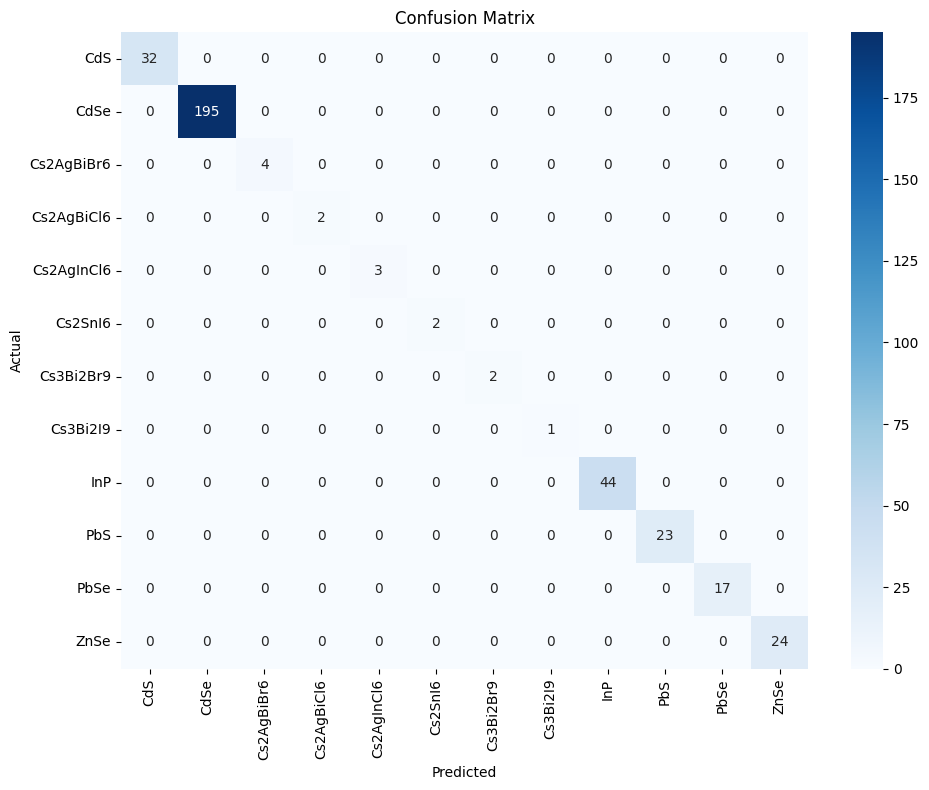

In [6]:
# ============================================================================
# 8. CLASSIFICATION RESULTS SUMMARY
# ============================================================================

print("\n" + "=" * 70)
print("CLASSIFICATION RESULTS SUMMARY")
print("=" * 70)

# Create summary dataframe
clf_summary = pd.DataFrame({
    'Model': list(classification_results.keys()),
    'F1 Score': [classification_results[m]['f1_score'] for m in classification_results],
    'Accuracy': [classification_results[m]['accuracy'] for m in classification_results],
    'Precision': [classification_results[m]['precision'] for m in classification_results],
    'Recall': [classification_results[m]['recall'] for m in classification_results],
    'Training Time (s)': [classification_results[m]['training_time'] for m in classification_results]
}).sort_values('F1 Score', ascending=False)

print("\n📊 Performance Comparison:")
print(clf_summary.to_string(index=False))

# Check if we achieved the target F1 score
print("\n🎯 Target Achievement:")
target_f1 = 0.9
best_f1 = clf_summary['F1 Score'].max()

if best_f1 >= target_f1:
    print(f"✅ SUCCESS: Achieved F1 score of {best_f1:.4f} (Target: {target_f1})")
    best_clf_model_name = clf_summary.iloc[0]['Model']
    print(f"🏆 Best model: {best_clf_model_name}")
else:
    print(f"⚠️ WARNING: Best F1 score is {best_f1:.4f} (Target: {target_f1})")
    print("Consider class balancing, feature engineering, or collecting more data.")

# Classification report for best model
print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT (Best Model)")
print("=" * 70)

y_pred_best = best_classification_model.predict(X_test_clf_scaled)
print("\n📋 Classification Report:")
print(classification_report(y_test_clf, y_pred_best,
                               target_names=le_target.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_clf, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()



In [18]:
# ============================================================================
# 3. REGRESSION TASK: PREDICTING DIAMETER
# ============================================================================

print("\n" + "=" * 70)
print("REGRESSION TASK: PREDICTING DIAMETER")
print("=" * 70)

# Check if 'Diameter' column exists
if 'Diameter' not in df.columns:
    print("❌ Error: 'Diameter' column not found in dataset!")
    print("Available columns:", df.columns.tolist())
else:
    # Create a copy of the dataframe for regression
    df_reg = df.copy()

    # Check if 'Compound' column exists - if yes, we need to handle it differently
    if 'Compound' in df_reg.columns:
        # Store it separately for classification task later
        compound_col = df_reg['Compound']
        df_reg = df_reg.drop('Compound', axis=1)
        print("✅ Removed 'Compound' column for regression task")

    # Separate features and target for regression
    X_reg = df_reg.drop('Diameter', axis=1)
    y_reg = df_reg['Diameter']

    print(f"\n📊 Regression features shape: {X_reg.shape}")
    print(f"📊 Regression target shape: {y_reg.shape}")

    # Identify categorical columns for encoding
    categorical_cols = X_reg.select_dtypes(include=['object', 'category']).columns
    print(f"\n🔤 Found {len(categorical_cols)} categorical columns: {list(categorical_cols)}")

    # Encode ALL categorical variables for regression
    if len(categorical_cols) > 0:
        print(f"\n🔤 Encoding categorical columns for regression...")
        label_encoders_reg = {}
        for col in categorical_cols:
            try:
                le = LabelEncoder()
                X_reg[col] = le.fit_transform(X_reg[col].astype(str))
                label_encoders_reg[col] = le
                print(f"  ✅ Encoded '{col}' ({X_reg[col].nunique()} unique values)")
            except Exception as e:
                print(f"  ❌ Error encoding '{col}': {e}")
        print("✅ All categorical columns encoded")

    # Check for any remaining non-numeric columns
    non_numeric_cols = X_reg.select_dtypes(exclude=['int64', 'float64']).columns
    if len(non_numeric_cols) > 0:
        print(f"\n⚠️ Warning: {len(non_numeric_cols)} non-numeric columns remaining: {list(non_numeric_cols)}")
        print("Attempting to convert to numeric...")
        for col in non_numeric_cols:
            try:
                X_reg[col] = pd.to_numeric(X_reg[col], errors='coerce')
                print(f"  ✅ Converted '{col}' to numeric")
            except:
                print(f"  ❌ Could not convert '{col}' to numeric - dropping column")
                X_reg = X_reg.drop(col, axis=1)

    # Convert all columns to numeric (float) to avoid any dtype issues
    for col in X_reg.columns:
        X_reg[col] = pd.to_numeric(X_reg[col], errors='coerce')

    print("\n✅ All regression features converted to float")

    # Check for NaN values after conversion
    nan_columns = X_reg.columns[X_reg.isnull().any()].tolist()
    if nan_columns:
        print(f"\n⚠️ Found NaN values in {len(nan_columns)} columns: {nan_columns}")
        print("Filling NaN values with median...")
        for col in nan_columns:
            median_val = X_reg[col].median()
            X_reg[col].fillna(median_val, inplace=True)
            print(f"  ✅ Filled NaN in '{col}' with median: {median_val:.4f}")

    # Remove columns with zero variance (which cause NaN when scaling)
    print("\n🔍 Checking for zero variance columns...")
    zero_var_cols = X_reg.columns[X_reg.std() == 0]
    if len(zero_var_cols) > 0:
        print(f"⚠️ Found {len(zero_var_cols)} zero variance columns: {list(zero_var_cols)}")
        print("Dropping zero variance columns...")
        X_reg = X_reg.drop(zero_var_cols, axis=1)
        print(f"✅ Dropped {len(zero_var_cols)} zero variance columns")

    # Also check for very low variance columns
    low_var_cols = X_reg.columns[X_reg.std() < 0.001]
    if len(low_var_cols) > 0:
        print(f"⚠️ Found {len(low_var_cols)} very low variance columns: {list(low_var_cols)}")
        print("⚠️ These may cause scaling issues but will be kept for now")

    # Split data for regression
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )

    print(f"\n📊 Regression Data Split:")
    print(f"Training set: {X_train_reg.shape[0]} samples, {X_train_reg.shape[1]} features")
    print(f"Testing set: {X_test_reg.shape[0]} samples")

    # Scale features for tree-based models
    print("\n⚖️ Scaling features...")
    try:
        scaler = StandardScaler()
        X_train_reg_scaled = scaler.fit_transform(X_train_reg)
        X_test_reg_scaled = scaler.transform(X_test_reg)

        # Check for NaN after scaling
        if np.isnan(X_train_reg_scaled).any():
            print("⚠️ Warning: NaN values found after scaling")
            print("Replacing NaN with 0 (likely from zero variance columns)...")
            X_train_reg_scaled = np.nan_to_num(X_train_reg_scaled, nan=0.0)
            X_test_reg_scaled = np.nan_to_num(X_test_reg_scaled, nan=0.0)

        print("✅ Features scaled")
    except Exception as e:
        print(f"❌ Error scaling features: {e}")
        print("⚠️ Using unscaled features instead...")
        X_train_reg_scaled = X_train_reg.values
        X_test_reg_scaled = X_test_reg.values



REGRESSION TASK: PREDICTING DIAMETER
✅ Removed 'Compound' column for regression task

📊 Regression features shape: (1124, 42)
📊 Regression target shape: (1124,)

🔤 Found 13 categorical columns: ['Cation1', 'Cation2', 'Cation3', 'Anion1', 'Cation1_source', 'Cation2_source', 'Cation3_source', 'Anion1_source', 'Additive1', 'Additive2', 'Additive3', 'Solvent_I', 'Solvent_II']

🔤 Encoding categorical columns for regression...
  ✅ Encoded 'Cation1' (5 unique values)
  ✅ Encoded 'Cation2' (3 unique values)
  ✅ Encoded 'Cation3' (2 unique values)
  ✅ Encoded 'Anion1' (6 unique values)
  ✅ Encoded 'Cation1_source' (35 unique values)
  ✅ Encoded 'Cation2_source' (14 unique values)
  ✅ Encoded 'Cation3_source' (9 unique values)
  ✅ Encoded 'Anion1_source' (30 unique values)
  ✅ Encoded 'Additive1' (17 unique values)
  ✅ Encoded 'Additive2' (24 unique values)
  ✅ Encoded 'Additive3' (10 unique values)
  ✅ Encoded 'Solvent_I' (20 unique values)
  ✅ Encoded 'Solvent_II' (12 unique values)
✅ All cat

In [19]:
    # ============================================================================
    # 4. REGRESSION MODEL DEFINITIONS AND HYPERPARAMETER GRIDS
    # ============================================================================

    print("\n" + "=" * 70)
    print("REGRESSION MODEL TRAINING WITH HYPERPARAMETER OPTIMIZATION")
    print("=" * 70)

    # Define regression models
    regression_models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42, verbosity=0, enable_categorical=False),
        'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
        'ExtraTrees': ExtraTreesRegressor(random_state=42)
    }

    # Define hyperparameter grids for regression
    regression_param_grids = {
        'RandomForest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']
        },
        'GradientBoosting': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'subsample': [0.8, 0.9]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        },
        'LightGBM': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [31, 50],
            'max_depth': [-1, 10],
            'min_child_samples': [20, 50],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        },
        'ExtraTrees': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']
        }
    }

    # Store regression results
    regression_results = {}
    best_regression_model = None
    best_regression_score = -np.inf

    # Train and optimize each regression model
    for model_name, model in tqdm(regression_models.items(), desc="Training Regression Models"):
        print(f"\n{'='*50}")
        print(f"Training {model_name}...")
        print(f"{'='*50}")

        # Use RandomizedSearchCV with error handling
        start_time = time.time()

        try:
            search = RandomizedSearchCV(
                model,
                regression_param_grids[model_name],
                n_iter=10,  # Reduced for stability
                cv=3,  # Reduced for stability
                scoring='r2',
                n_jobs=-1,
                random_state=42,
                verbose=0,
                error_score='raise'  # Changed to see actual errors
            )

            search.fit(X_train_reg_scaled, y_train_reg)

            # Make predictions
            y_pred = search.best_estimator_.predict(X_test_reg_scaled)

            # Calculate metrics
            r2 = r2_score(y_test_reg, y_pred)
            mse = mean_squared_error(y_test_reg, y_pred)
            mae = mean_absolute_error(y_test_reg, y_pred)
            rmse = np.sqrt(mse)

            training_time = time.time() - start_time

            # Store results
            regression_results[model_name] = {
                'model': search.best_estimator_,
                'best_params': search.best_params_,
                'r2_score': r2,
                'rmse': rmse,
                'mae': mae,
                'training_time': training_time
            }

            print(f"✅ Best R² Score: {r2:.4f}")
            print(f"📊 RMSE: {rmse:.4f}")
            print(f"📊 MAE: {mae:.4f}")
            print(f"⏱️ Training time: {training_time:.2f} seconds")
            print(f"🔧 Best parameters: {search.best_params_}")

            # Update best model
            if r2 > best_regression_score:
                best_regression_score = r2
                best_regression_model = search.best_estimator_

        except Exception as e:
            print(f"❌ Error training {model_name}: {str(e)[:200]}...")

            # Try with default parameters as fallback
            print("⚠️ Trying with default parameters...")
            try:
                model.fit(X_train_reg_scaled, y_train_reg)
                y_pred = model.predict(X_test_reg_scaled)
                r2 = r2_score(y_test_reg, y_pred)

                regression_results[model_name] = {
                    'model': model,
                    'best_params': 'default',
                    'r2_score': r2,
                    'rmse': np.sqrt(mean_squared_error(y_test_reg, y_pred)),
                    'mae': mean_absolute_error(y_test_reg, y_pred),
                    'training_time': time.time() - start_time
                }

                print(f"✅ Default R² Score: {r2:.4f}")

                if r2 > best_regression_score:
                    best_regression_score = r2
                    best_regression_model = model

            except Exception as e2:
                print(f"❌ Failed with default parameters too: {str(e2)[:200]}...")
                regression_results[model_name] = {
                    'model': None,
                    'best_params': 'failed',
                    'r2_score': -1,
                    'rmse': -1,
                    'mae': -1,
                    'training_time': time.time() - start_time
                }


REGRESSION MODEL TRAINING WITH HYPERPARAMETER OPTIMIZATION


Training Regression Models:   0%|          | 0/5 [00:00<?, ?it/s]


Training RandomForest...


Training Regression Models:  20%|██        | 1/5 [00:12<00:48, 12.15s/it]

✅ Best R² Score: 0.5706
📊 RMSE: 7.9047
📊 MAE: 1.6538
⏱️ Training time: 12.15 seconds
🔧 Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}

Training GradientBoosting...


Training Regression Models:  40%|████      | 2/5 [00:21<00:31, 10.52s/it]

✅ Best R² Score: 0.8197
📊 RMSE: 5.1224
📊 MAE: 1.3399
⏱️ Training time: 9.38 seconds
🔧 Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}

Training XGBoost...


Training Regression Models:  60%|██████    | 3/5 [00:24<00:14,  7.01s/it]

✅ Best R² Score: 0.6850
📊 RMSE: 6.7700
📊 MAE: 1.5333
⏱️ Training time: 2.84 seconds
🔧 Best parameters: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Training LightGBM...


Training Regression Models:  80%|████████  | 4/5 [00:29<00:06,  6.41s/it]

✅ Best R² Score: 0.3424
📊 RMSE: 9.7818
📊 MAE: 1.9566
⏱️ Training time: 5.48 seconds
🔧 Best parameters: {'subsample': 0.9, 'num_leaves': 50, 'n_estimators': 200, 'min_child_samples': 50, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.9}

Training ExtraTrees...


Training Regression Models: 100%|██████████| 5/5 [00:36<00:00,  7.21s/it]

✅ Best R² Score: 0.5136
📊 RMSE: 8.4127
📊 MAE: 1.4659
⏱️ Training time: 6.17 seconds
🔧 Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


In [24]:
# ============================================================================
# REINFORCEMENT LEARNING AGENT FOR CHEMICAL COMPOUND EXPLORATION
# ============================================================================

import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')
import re

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

# Visualization
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# ============================================================================
# 1. DATA PREPARATION FOR RL AGENT
# ============================================================================

print("=" * 80)
print("REINFORCEMENT LEARNING AGENT FOR CHEMICAL COMPOUND EXPLORATION")
print("=" * 80)

# Load the dataset (using the previously loaded df)
print("\n📊 Preparing data for RL agent...")

# Remove DOI column if present
if 'DOI' in df.columns:
    df_rl = df.drop('DOI', axis=1)
    print("✅ Removed 'DOI' column")
else:
    df_rl = df.copy()

# Ensure we have the required columns
if 'Compound' not in df_rl.columns or 'Diameter' not in df_rl.columns:
    print("❌ Error: Dataset must contain 'Compound' and 'Diameter' columns")
    print(f"Available columns: {df_rl.columns.tolist()}")
else:
    print(f"✅ Dataset loaded: {df_rl.shape[0]} compounds, {df_rl.shape[1]} features")

    # Get unique compounds
    unique_compounds = df_rl['Compound'].unique()
    print(f"📊 Unique compounds in database: {len(unique_compounds)}")

    # Display some statistics
    print(f"\n📈 Diameter statistics:")
    print(f"  Min: {df_rl['Diameter'].min():.2f}")
    print(f"  Max: {df_rl['Diameter'].max():.2f}")
    print(f"  Mean: {df_rl['Diameter'].mean():.2f}")
    print(f"  Std: {df_rl['Diameter'].std():.2f}")

    # Show compound distribution
    compound_counts = df_rl['Compound'].value_counts()
    print(f"\n📊 Top 5 most frequent compounds:")
    for compound, count in compound_counts.head().items():
        print(f"  {compound}: {count} samples")

# ============================================================================
# 2. PREPARE MODELS FOR RL AGENT (CLASSIFICATION FIRST, REGRESSION SECOND)
# ============================================================================

print("\n" + "=" * 80)
print("TRAINING MODELS FOR RL AGENT")
print("=" * 80)

def prepare_rl_models(df_rl):
    """
    Prepare classification and regression models for the RL agent.
    Classification model predicts compound from features.
    Regression model predicts diameter from features (including compound).
    """

    # ============================================================================
    # 2.1 CLASSIFICATION MODEL: Predict Compound from Features
    # ============================================================================

    print("\n🔬 Training Classification Model (Compound Prediction)...")

    # Prepare data for classification
    X_clf = df_rl.drop(['Compound', 'Diameter'], axis=1)
    y_clf = df_rl['Compound']

    # Encode categorical features
    categorical_cols = X_clf.select_dtypes(include=['object', 'category']).columns
    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        X_clf[col] = le.fit_transform(X_clf[col].astype(str))
        label_encoders[col] = le

    # Encode target
    le_target = LabelEncoder()
    y_clf_encoded = le_target.fit_transform(y_clf)

    # Train classifier
    clf_model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        verbosity=0
    )

    clf_model.fit(X_clf, y_clf_encoded)

    # Test accuracy
    train_accuracy = clf_model.score(X_clf, y_clf_encoded)
    print(f"✅ Classification model trained - Train accuracy: {train_accuracy:.4f}")
    print(f"   Number of classes: {len(le_target.classes_)}")

    # ============================================================================
    # 2.2 REGRESSION MODEL: Predict Diameter from Features (including Compound)
    # ============================================================================

    print("\n📏 Training Regression Model (Diameter Prediction)...")

    # Prepare data for regression
    df_reg = df_rl.copy()

    # Encode compound for regression
    le_compound = LabelEncoder()
    df_reg['Compound_encoded'] = le_compound.fit_transform(df_reg['Compound'])

    # Prepare features and target
    X_reg = df_reg.drop('Diameter', axis=1)
    y_reg = df_reg['Diameter']

    # Remove the original compound column (use encoded version)
    if 'Compound' in X_reg.columns:
        X_reg = X_reg.drop('Compound', axis=1)

    # Encode remaining categorical features
    for col in X_reg.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X_reg[col] = le.fit_transform(X_reg[col].astype(str))
        label_encoders[col] = le

    # Train regressor
    reg_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        verbosity=0
    )

    reg_model.fit(X_reg, y_reg)

    # Test performance
    y_pred = reg_model.predict(X_reg)
    r2 = 1 - np.sum((y_reg - y_pred) ** 2) / np.sum((y_reg - np.mean(y_reg)) ** 2)
    rmse = np.sqrt(np.mean((y_reg - y_pred) ** 2))

    print(f"✅ Regression model trained - R²: {r2:.4f}, RMSE: {rmse:.4f}")

    # ============================================================================
    # 2.3 CREATE FEATURE SPACE FOR RL AGENT
    # ============================================================================

    print("\n🗺️ Creating feature space for RL agent...")

    # Get feature ranges for exploration
    feature_ranges = {}
    for col in X_clf.columns:
        if col in X_clf.select_dtypes(include=[np.number]).columns:
            min_val = X_clf[col].min()
            max_val = X_clf[col].max()
            feature_ranges[col] = (min_val, max_val)

    print(f"✅ Feature space created with {len(feature_ranges)} numerical features")

    return {
        'clf_model': clf_model,
        'reg_model': reg_model,
        'le_target': le_target,
        'le_compound': le_compound,
        'feature_ranges': feature_ranges,
        'original_features': X_clf.columns.tolist(),
        'compound_list': unique_compounds.tolist(),
        'diameter_range': (df_rl['Diameter'].min(), df_rl['Diameter'].max())
    }

# Train the models
rl_models = prepare_rl_models(df_rl)

# ============================================================================
# 3. Q-LEARNING RL AGENT IMPLEMENTATION
# ============================================================================

print("\n" + "=" * 80)
print("Q-LEARNING REINFORCEMENT LEARNING AGENT")
print("=" * 80)

class CompoundExplorationAgent:
    """RL agent for exploring chemical compound space to find target compounds/diameters."""

    def __init__(self, models, num_actions=10, learning_rate=0.1, discount_factor=0.9,
                 exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.01):

        self.models = models
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate

        # Initialize Q-table (state: compound index, action: feature modification)
        self.num_states = len(models['compound_list'])
        self.q_table = np.zeros((self.num_states, num_actions))

        # Action descriptions
        self.action_descriptions = [
            "Increase main feature 1",
            "Decrease main feature 1",
            "Increase main feature 2",
            "Decrease main feature 2",
            "Increase temperature parameter",
            "Decrease temperature parameter",
            "Increase pressure parameter",
            "Decrease pressure parameter",
            "Increase time parameter",
            "Decrease time parameter"
        ]

        # Track episode statistics
        self.episode_rewards = []
        self.episode_steps = []

        # Parse compound formulas for element comparison
        self.compound_elements = self._parse_compound_elements(models['compound_list'])

        print(f"✅ RL Agent initialized with {self.num_states} states and {num_actions} actions")

    def _parse_compound_elements(self, compound_list):
        """Parse chemical formulas to extract elements."""
        compound_elements = {}
        for compound in compound_list:
            # Parse chemical formula (e.g., "CdSe", "ZnS", "PbTe")
            # This regex captures element symbols (one or two letters) followed optionally by numbers
            elements = re.findall(r'[A-Z][a-z]?\d*', compound)
            # Remove numbers to get just element symbols
            element_set = set()
            for elem in elements:
                # Remove numbers from the element (e.g., "Se2" -> "Se")
                element_symbol = re.sub(r'\d+', '', elem)
                element_set.add(element_symbol)
            compound_elements[compound] = element_set
        return compound_elements

    def _compare_compounds(self, pred_compound, target_compound):
        """
        Compare two compounds and return similarity metrics.
        Returns: (element_match_score, is_same_type, is_partial_match)
        """
        pred_elements = self.compound_elements.get(pred_compound, set())
        target_elements = self.compound_elements.get(target_compound, set())

        if not pred_elements or not target_elements:
            return 0.0, False, False

        # Calculate element overlap
        common_elements = pred_elements.intersection(target_elements)
        all_elements = pred_elements.union(target_elements)

        # Element match score (0-1)
        if len(all_elements) > 0:
            element_match_score = len(common_elements) / len(all_elements)
        else:
            element_match_score = 0.0

        # Check if compounds are same type (binary, ternary, etc.)
        is_same_type = len(pred_elements) == len(target_elements)

        # Check if it's a partial match (at least one element in common)
        is_partial_match = len(common_elements) > 0

        return element_match_score, is_same_type, is_partial_match

    def get_state_index(self, compound_name):
        """Convert compound name to state index."""
        if compound_name in self.models['compound_list']:
            return self.models['compound_list'].index(compound_name)
        else:
            return -1  # Invalid state

    def get_compound_name(self, state_index):
        """Convert state index to compound name."""
        if 0 <= state_index < len(self.models['compound_list']):
            return self.models['compound_list'][state_index]
        return "Unknown"

    def get_reward(self, predicted_compound, predicted_diameter,
                   target_compound, target_diameter, current_features=None):
        """
        Calculate reward based on how close we are to target.
        Higher reward for closer matches to both compound and diameter.
        Penalties for wrong compounds based on element mismatch.
        """

        # ============================================================
        # 1. COMPOUND MATCH REWARD/PENALTY
        # ============================================================

        if predicted_compound == target_compound:
            # Perfect compound match
            compound_reward = 5.0  # Base reward for correct compound
            compound_penalty = 0.0
            match_type = "PERFECT"

        else:
            # Calculate compound similarity
            element_match_score, is_same_type, is_partial_match = self._compare_compounds(
                predicted_compound, target_compound
            )

            # Apply penalties based on element mismatch
            if is_partial_match:
                # Partial match (e.g., CdS vs CdSe)
                if element_match_score >= 0.5:
                    # Close match (e.g., CdS vs CdSe, ZnS vs ZnSe)
                    compound_reward = 1.0  # Small positive for being close
                    compound_penalty = -2.0  # Small penalty
                    match_type = "PARTIAL_MATCH"
                else:
                    # Some elements match but not enough
                    compound_reward = 0.0
                    compound_penalty = -4.0  # Medium penalty
                    match_type = "WEAK_MATCH"
            else:
                # No elements in common (e.g., CdS vs PbTe)
                compound_reward = 0.0
                compound_penalty = -8.0  # Large penalty
                match_type = "NO_MATCH"

        # ============================================================
        # 2. DIAMETER REWARD
        # ============================================================

        diameter_range = self.models['diameter_range'][1] - self.models['diameter_range'][0]
        if diameter_range > 0:
            diameter_error = abs(predicted_diameter - target_diameter)
            diameter_reward = 5.0 * (1.0 - min(diameter_error / diameter_range, 1.0))
        else:
            diameter_reward = 5.0 if abs(predicted_diameter - target_diameter) < 0.01 else 0.0

        # ============================================================
        # 3. FEATURE STABILITY BONUS
        # ============================================================

        stability_bonus = 0.0
        if current_features is not None:
            # Check if features are within reasonable ranges
            valid_features = 0
            for feature, (min_val, max_val) in self.models['feature_ranges'].items():
                if feature in current_features:
                    val = current_features[feature]
                    if min_val <= val <= max_val:
                        valid_features += 1

            stability_bonus = valid_features / len(self.models['feature_ranges']) * 1.0

        # ============================================================
        # 4. CONFIDENCE BONUS (if we have prediction confidence)
        # ============================================================

        confidence_bonus = 0.0
        # This would be added if we track classification confidence

        # ============================================================
        # 5. COMBINE ALL COMPONENTS
        # ============================================================

        total_reward = (
            compound_reward +
            compound_penalty +
            diameter_reward +
            stability_bonus +
            confidence_bonus
        )

        # Ensure reward is not too negative
        total_reward = max(total_reward, -10.0)

        return total_reward, {
            'compound_reward': compound_reward,
            'compound_penalty': compound_penalty,
            'diameter_reward': diameter_reward,
            'stability_bonus': stability_bonus,
            'confidence_bonus': confidence_bonus,
            'match_type': match_type,
            'element_match_score': element_match_score if predicted_compound != target_compound else 1.0
        }

    def modify_features(self, current_features, action):
        """Modify features based on the selected action."""
        modified_features = current_features.copy()

        # Get feature names for modification
        feature_names = list(self.models['feature_ranges'].keys())
        if len(feature_names) == 0:
            return modified_features

        # Map action to feature modification
        if action == 0:  # Increase main feature 1
            if len(feature_names) > 0:
                feature = feature_names[0]
                min_val, max_val = self.models['feature_ranges'][feature]
                modified_features[feature] = min(max_val, modified_features.get(feature, min_val) + 0.1 * (max_val - min_val))

        elif action == 1:  # Decrease main feature 1
            if len(feature_names) > 0:
                feature = feature_names[0]
                min_val, max_val = self.models['feature_ranges'][feature]
                modified_features[feature] = max(min_val, modified_features.get(feature, max_val) - 0.1 * (max_val - min_val))

        elif action == 2:  # Increase main feature 2
            if len(feature_names) > 1:
                feature = feature_names[1]
                min_val, max_val = self.models['feature_ranges'][feature]
                modified_features[feature] = min(max_val, modified_features.get(feature, min_val) + 0.1 * (max_val - min_val))

        elif action == 3:  # Decrease main feature 2
            if len(feature_names) > 1:
                feature = feature_names[1]
                min_val, max_val = self.models['feature_ranges'][feature]
                modified_features[feature] = max(min_val, modified_features.get(feature, max_val) - 0.1 * (max_val - min_val))

        # For other actions, modify random features
        else:
            # Select a random feature to modify
            feature = random.choice(feature_names)
            min_val, max_val = self.models['feature_ranges'][feature]

            if action % 2 == 0:  # Even actions: increase
                modified_features[feature] = min(max_val, modified_features.get(feature, min_val) + 0.05 * (max_val - min_val))
            else:  # Odd actions: decrease
                modified_features[feature] = max(min_val, modified_features.get(feature, max_val) - 0.05 * (max_val - min_val))

        return modified_features

    def predict_from_features(self, features_dict):
        """Use trained models to predict compound and diameter from features."""

        # Convert features to dataframe
        features_df = pd.DataFrame([features_dict])

        # Ensure all expected features are present
        for feature in self.models['original_features']:
            if feature not in features_df.columns:
                # Use median value from training
                if feature in self.models['feature_ranges']:
                    min_val, max_val = self.models['feature_ranges'][feature]
                    features_df[feature] = (min_val + max_val) / 2

        # Reorder columns to match training
        features_df = features_df[self.models['original_features']]

        # Predict compound
        compound_proba = self.models['clf_model'].predict_proba(features_df)[0]
        compound_idx = np.argmax(compound_proba)
        predicted_compound = self.models['le_target'].classes_[compound_idx]
        confidence = compound_proba[compound_idx]

        # Prepare features for diameter prediction (include compound)
        reg_features = features_df.copy()

        # Add encoded compound
        if predicted_compound in self.models['le_compound'].classes_:
            compound_encoded = self.models['le_compound'].transform([predicted_compound])[0]
            reg_features['Compound_encoded'] = compound_encoded
        else:
            # Use most common compound if prediction is outside training
            reg_features['Compound_encoded'] = 0

        # Predict diameter
        predicted_diameter = self.models['reg_model'].predict(reg_features)[0]

        return predicted_compound, predicted_diameter, confidence

    def choose_action(self, state):
        """Choose action using epsilon-greedy policy."""
        if random.random() < self.exploration_rate:
            # Explore: random action
            return random.randint(0, self.num_actions - 1)
        else:
            # Exploit: best action from Q-table
            return np.argmax(self.q_table[state])

    def update_q_value(self, state, action, reward, next_state):
        """Update Q-value using Q-learning update rule."""
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

    def train_episode(self, target_compound, target_diameter, max_steps=50, verbose=True):
        """Train for one episode."""
        # Initialize state (start from a random compound in the database)
        if target_compound in self.models['compound_list']:
            start_compound = target_compound
        else:
            start_compound = random.choice(self.models['compound_list'])

        state = self.get_state_index(start_compound)

        # Initialize random features
        current_features = {}
        for feature, (min_val, max_val) in self.models['feature_ranges'].items():
            current_features[feature] = random.uniform(min_val, max_val)

        total_reward = 0
        steps = 0
        best_reward = -np.inf
        best_compound = start_compound
        best_diameter = 0
        best_features = current_features.copy()

        if verbose:
            print(f"\n🎯 Target: Compound='{target_compound}', Diameter={target_diameter:.2f}")
            print(f"🚀 Starting from: Compound='{start_compound}'")
            print("-" * 70)

        for step in range(max_steps):
            # Choose action
            action = self.choose_action(state)

            # Modify features based on action
            new_features = self.modify_features(current_features, action)

            # Predict compound and diameter with new features
            predicted_compound, predicted_diameter, confidence = self.predict_from_features(new_features)

            # Get new state (based on predicted compound)
            next_state = self.get_state_index(predicted_compound)
            if next_state == -1:  # Invalid compound predicted
                next_state = state  # Stay in current state
                predicted_compound = self.get_compound_name(state)

            # Calculate reward
            reward, reward_breakdown = self.get_reward(
                predicted_compound, predicted_diameter,
                target_compound, target_diameter,
                new_features
            )

            # Update Q-table
            self.update_q_value(state, action, reward, next_state)

            # Update statistics
            total_reward += reward
            steps += 1

            # Track best result
            if reward > best_reward:
                best_reward = reward
                best_compound = predicted_compound
                best_diameter = predicted_diameter
                best_features = new_features.copy()

            # Update current state and features
            state = next_state
            current_features = new_features

            # Display step information
            if verbose and step % 3 == 0:  # Show more frequently
                match_type = reward_breakdown['match_type']
                if match_type == "PERFECT":
                    match_symbol = "✅"
                elif match_type == "PARTIAL_MATCH":
                    match_symbol = "⚠️"
                else:
                    match_symbol = "❌"

                print(f"Step {step:3d}: {match_symbol} Action='{self.action_descriptions[action]}'")
                print(f"       Predicted: {match_symbol} '{predicted_compound}' ({confidence:.2%}), "
                      f"Diameter={predicted_diameter:.2f}")
                print(f"       Reward: {reward:6.2f} [C:{reward_breakdown['compound_reward']:+.1f}, "
                      f"P:{reward_breakdown['compound_penalty']:+.1f}, "
                      f"D:{reward_breakdown['diameter_reward']:+.1f}, "
                      f"S:{reward_breakdown['stability_bonus']:+.1f}]")
                print(f"       Match: {match_type}")
                if predicted_compound != target_compound and 'element_match_score' in reward_breakdown:
                    print(f"       Element similarity: {reward_breakdown['element_match_score']:.2%}")
                print("-" * 70)

            # Early stopping if we found a perfect match
            if predicted_compound == target_compound and abs(predicted_diameter - target_diameter) < 0.1:
                if verbose:
                    print(f"🎉 Perfect match found at step {step}!")
                break

        # Decay exploration rate
        self.exploration_rate = max(self.min_exploration_rate,
                                   self.exploration_rate * self.exploration_decay)

        # Store episode statistics
        self.episode_rewards.append(total_reward)
        self.episode_steps.append(steps)

        if verbose:
            print(f"\n📊 Episode Summary:")
            print(f"   Total steps: {steps}")
            print(f"   Total reward: {total_reward:.2f}")
            print(f"   Best found: Compound='{best_compound}', Diameter={best_diameter:.2f}")
            print(f"   Exploration rate: {self.exploration_rate:.3f}")

        return best_compound, best_diameter, best_features, best_reward

    def plot_training_progress(self):
        """Plot training progress."""
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Plot rewards
        axes[0].plot(self.episode_rewards)
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Total Reward')
        axes[0].set_title('Rewards per Episode')
        axes[0].grid(True, alpha=0.3)

        # Plot steps
        axes[1].plot(self.episode_steps)
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Steps per Episode')
        axes[1].set_title('Episode Length')
        axes[1].grid(True, alpha=0.3)

        # Plot moving average of rewards
        window_size = max(1, len(self.episode_rewards) // 10)
        if len(self.episode_rewards) >= window_size:
            moving_avg = np.convolve(self.episode_rewards,
                                    np.ones(window_size)/window_size,
                                    mode='valid')
            axes[2].plot(range(window_size-1, len(self.episode_rewards)), moving_avg)
            axes[2].set_xlabel('Episode')
            axes[2].set_ylabel('Moving Average Reward')
            axes[2].set_title(f'Moving Average (window={window_size})')
            axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Initialize RL agent
print("\n🤖 Initializing Q-Learning Agent...")
rl_agent = CompoundExplorationAgent(
    models=rl_models,
    num_actions=10,
    learning_rate=0.1,
    discount_factor=0.9,
    exploration_rate=1.0,
    exploration_decay=0.98,
    min_exploration_rate=0.01
)

# ============================================================================
# 4. INTERACTIVE USER INTERFACE
# ============================================================================

print("\n" + "=" * 80)
print("INTERACTIVE COMPOUND EXPLORATION")
print("=" * 80)

def get_user_target():
    """Get target compound and diameter from user."""
    while True:
        print(f"\n📋 Available compounds ({len(rl_models['compound_list'])}):")
        # Show compounds in a readable format
        compounds = rl_models['compound_list']
        compounds_per_line = 5
        for i in range(0, min(20, len(compounds)), compounds_per_line):
            print("  " + ", ".join(compounds[i:i+compounds_per_line]))
        if len(compounds) > 20:
            print(f"  ... and {len(compounds) - 20} more")

        target_compound = input("\n🎯 Enter target compound name: ").strip()

        if target_compound in rl_models['compound_list']:
            break
        else:
            print(f"❌ Compound '{target_compound}' not found in database.")
            print("   Please choose from the available compounds.")

    while True:
        try:
            target_diameter = float(input("📏 Enter target diameter: "))

            # Check if diameter is within reasonable range
            min_d, max_d = rl_models['diameter_range']
            if min_d <= target_diameter <= max_d:
                break
            else:
                print(f"⚠️ Warning: Diameter {target_diameter:.2f} is outside typical range [{min_d:.2f}, {max_d:.2f}]")
                proceed = input("   Do you want to proceed anyway? (y/n): ").lower()
                if proceed == 'y':
                    break
        except ValueError:
            print("❌ Please enter a valid number for diameter.")

    return target_compound, target_diameter

def run_exploration_episodes(target_compound, target_diameter, num_episodes=20):
    """Run multiple exploration episodes."""
    print(f"\n{'='*80}")
    print(f"EXPLORING FOR: Compound='{target_compound}', Diameter={target_diameter:.2f}")
    print(f"Training for {num_episodes} episodes...")
    print(f"{'='*80}")

    best_overall_reward = -np.inf
    best_results = None

    for episode in range(num_episodes):
        print(f"\n📈 Episode {episode + 1}/{num_episodes}")

        # Add sleep for better visualization
        time.sleep(1.0)

        # Train for one episode
        verbose_mode = (episode % 5 == 0) or (episode == num_episodes - 1)
        best_compound, best_diameter, best_features, best_reward = rl_agent.train_episode(
            target_compound=target_compound,
            target_diameter=target_diameter,
            max_steps=30,
            verbose=verbose_mode
        )

        # Track best overall result
        if best_reward > best_overall_reward:
            best_overall_reward = best_reward
            best_results = {
                'compound': best_compound,
                'diameter': best_diameter,
                'features': best_features,
                'reward': best_reward
            }

        # Display non-verbose episode summary
        if not verbose_mode:
            # Compare compounds for penalty information
            element_match_score, _, _ = rl_agent._compare_compounds(best_compound, target_compound)
            if best_compound == target_compound:
                match_info = "✅ PERFECT"
            elif element_match_score > 0:
                match_info = f"⚠️ PARTIAL ({element_match_score:.0%} match)"
            else:
                match_info = "❌ NO MATCH"

            print(f"   Best reward: {best_reward:.2f}, Found: {best_compound} {match_info}")

    # Display final results
    print(f"\n{'='*80}")
    print("EXPLORATION COMPLETE")
    print(f"{'='*80}")

    if best_results:
        print(f"\n🏆 BEST RESULT FOUND:")
        print(f"   Compound: {best_results['compound']}")
        print(f"   Diameter: {best_results['diameter']:.2f} (Target: {target_diameter:.2f})")
        print(f"   Reward: {best_results['reward']:.2f}")

        # Calculate compound similarity
        element_match_score, is_same_type, is_partial_match = rl_agent._compare_compounds(
            best_results['compound'], target_compound
        )

        print(f"\n📊 Compound Analysis:")
        if best_results['compound'] == target_compound:
            print(f"   ✅ PERFECT MATCH: Correct compound")
        elif is_partial_match:
            print(f"   ⚠️ PARTIAL MATCH: {element_match_score:.0%} element similarity")
            if element_match_score >= 0.5:
                print(f"      (Similar compound family, e.g., CdS vs CdSe)")
            else:
                print(f"      (Some common elements)")
        else:
            print(f"   ❌ NO MATCH: Completely different compounds")

        # Calculate diameter error
        diameter_error = abs(best_results['diameter'] - target_diameter)
        print(f"\n📏 Diameter Analysis:")
        print(f"   Error: {diameter_error:.2f}")
        if diameter_error < 0.1:
            print(f"   ✅ Excellent diameter match!")
        elif diameter_error < 0.5:
            print(f"   ⚠️ Acceptable diameter match")
        else:
            print(f"   ❌ Poor diameter match")

        if best_results['compound'] == target_compound and diameter_error < 0.5:
            print(f"\n🎉 SUCCESS: Found close match to target!")
        else:
            print(f"\n🔍 CONTINUE: Try more episodes or adjust parameters")
            interactive_session()

    # Show training progress
    rl_agent.plot_training_progress()

    return best_results

def interactive_session():
    """Run interactive session with user."""
    print("\n👋 Welcome to the Chemical Compound Exploration Agent!")
    print("This RL agent will explore the chemical space to find compounds with specific properties.")
    print("\n📋 REWARD SYSTEM:")
    print("  ✅ Perfect compound match: +5.0")
    print("  ⚠️ Partial match (e.g., CdS vs CdSe): +1.0 -2.0 = -1.0")
    print("  ❌ No element match: -8.0 penalty")
    print("  📏 Diameter match: up to +5.0")
    print("  ⚖️ Feature stability: up to +1.0")

    session_active = True

    while session_active:
        print(f"\n{'='*80}")
        print("MAIN MENU")
        print(f"{'='*80}")
        print("1. Set new target and explore")
        print("2. View available compounds")
        print("3. View agent statistics")
        print("4. Reset agent (clear learning)")
        print("5. Exit")

        choice = input("\nSelect option (1-5): ").strip()

        if choice == '1':
            # Get target from user
            target_compound, target_diameter = get_user_target()

            # Get number of episodes
            while True:
                try:
                    num_episodes = int(input("Number of exploration episodes (10-100): "))
                    if 10 <= num_episodes <= 100:
                        break
                    else:
                        print("Please enter a number between 10 and 100.")
                except ValueError:
                    print("Please enter a valid number.")

            # Run exploration
            results = run_exploration_episodes(target_compound, target_diameter, num_episodes)

            # Ask if user wants to save results
            if results:
                save = input("\n💾 Save these results to file? (y/n): ").lower()
                if save == 'y':
                    filename = f"exploration_results_{target_compound}_{target_diameter:.1f}.txt"
                    with open(filename, 'w') as f:
                        f.write(f"Target Compound: {target_compound}\n")
                        f.write(f"Target Diameter: {target_diameter:.2f}\n\n")
                        f.write(f"Best Found Compound: {results['compound']}\n")
                        f.write(f"Best Found Diameter: {results['diameter']:.2f}\n")
                        f.write(f"Reward: {results['reward']:.2f}\n\n")

                        # Add compound analysis
                        element_match_score, _, _ = rl_agent._compare_compounds(results['compound'], target_compound)
                        f.write(f"Element Similarity: {element_match_score:.2%}\n\n")

                        f.write("Features:\n")
                        for feature, value in results['features'].items():
                            f.write(f"  {feature}: {value:.4f}\n")
                    print(f"✅ Results saved to {filename}")

        elif choice == '2':
            print(f"\n📋 Available Compounds ({len(rl_models['compound_list'])}):")
            compounds = rl_models['compound_list']
            compounds_per_line = 5
            for i in range(0, len(compounds), compounds_per_line):
                print("  " + ", ".join(compounds[i:i+compounds_per_line]))

        elif choice == '3':
            print(f"\n📊 Agent Statistics:")
            print(f"   Number of states: {rl_agent.num_states}")
            print(f"   Number of actions: {rl_agent.num_actions}")
            print(f"   Episodes trained: {len(rl_agent.episode_rewards)}")
            if rl_agent.episode_rewards:
                print(f"   Average reward: {np.mean(rl_agent.episode_rewards):.2f}")
                print(f"   Best reward: {np.max(rl_agent.episode_rewards):.2f}")
                print(f"   Worst reward: {np.min(rl_agent.episode_rewards):.2f}")
                print(f"   Exploration rate: {rl_agent.exploration_rate:.3f}")

            # Show Q-table statistics
            print(f"\n🧠 Q-Table Statistics:")
            print(f"   Mean Q-value: {np.mean(rl_agent.q_table):.4f}")
            print(f"   Max Q-value: {np.max(rl_agent.q_table):.4f}")
            print(f"   Min Q-value: {np.min(rl_agent.q_table):.4f}")

            # Show penalty statistics
            print(f"\n⚖️ Reward/Penalty Statistics:")
            negative_rewards = [r for r in rl_agent.episode_rewards if r < 0]
            if negative_rewards:
                print(f"   Episodes with penalties: {len(negative_rewards)}/{len(rl_agent.episode_rewards)}")
                print(f"   Average penalty: {np.mean(negative_rewards):.2f}")

        elif choice == '4':
            confirm = input("\n⚠️ Are you sure you want to reset the agent? All learning will be lost. (y/n): ").lower()
            if confirm == 'y':
                # Reinitialize agent
                rl_agent = CompoundExplorationAgent(
                    models=rl_models,
                    num_actions=10,
                    learning_rate=0.1,
                    discount_factor=0.9,
                    exploration_rate=1.0,
                    exploration_decay=0.98,
                    min_exploration_rate=0.01
                )
                print("✅ Agent reset successfully!")

        elif choice == '5':
            print("\n👋 Thank you for using the Chemical Compound Exploration Agent!")
            session_active = False

        else:
            print("❌ Invalid choice. Please select 1-5.")

# ============================================================================
# 5. RUN INTERACTIVE SESSION
# ============================================================================

# Start interactive session
try:
    interactive_session()
except KeyboardInterrupt:
    print("\n\n⚠️ Program interrupted by user.")
except Exception as e:
    print(f"\n❌ An error occurred: {str(e)}")
    print("Please restart the program.")

print("\n" + "=" * 80)
print("PROGRAM COMPLETED")
print("=" * 80)

REINFORCEMENT LEARNING AGENT FOR CHEMICAL COMPOUND EXPLORATION

📊 Preparing data for RL agent...
✅ Dataset loaded: 1124 compounds, 44 features
📊 Unique compounds in database: 12

📈 Diameter statistics:
  Min: 0.85
  Max: 200.00
  Mean: 5.37
  Std: 11.09

📊 Top 5 most frequent compounds:
  CdSe: 357 samples
  InP: 220 samples
  CdS: 161 samples
  ZnSe: 121 samples
  PbS: 114 samples

TRAINING MODELS FOR RL AGENT

🔬 Training Classification Model (Compound Prediction)...
✅ Classification model trained - Train accuracy: 1.0000
   Number of classes: 12

📏 Training Regression Model (Diameter Prediction)...
✅ Regression model trained - R²: 0.8636, RMSE: 4.0923

🗺️ Creating feature space for RL agent...
✅ Feature space created with 42 numerical features

Q-LEARNING REINFORCEMENT LEARNING AGENT

🤖 Initializing Q-Learning Agent...
✅ RL Agent initialized with 12 states and 10 actions

INTERACTIVE COMPOUND EXPLORATION

👋 Welcome to the Chemical Compound Exploration Agent!
This RL agent will explor

REINFORCEMENT LEARNING AGENT FOR CHEMICAL COMPOUND EXPLORATION

📊 Preparing data for RL agent...
✅ Dataset loaded: 1124 compounds, 44 features
📊 Unique compounds in database: 12

📈 Diameter statistics:
  Min: 0.85
  Max: 200.00
  Mean: 5.37
  Std: 11.09

📊 Top 5 most frequent compounds:
  CdSe: 357 samples
  InP: 220 samples
  CdS: 161 samples
  ZnSe: 121 samples
  PbS: 114 samples

TRAINING MODELS FOR RL AGENT

🔬 Training Classification Model (Compound Prediction)...
✅ Classification model trained - Train accuracy: 1.0000
   Number of classes: 12

📏 Training Regression Model (Diameter Prediction)...
✅ Regression model trained - R²: 0.8636, RMSE: 4.0923

🗺️ Creating feature space for RL agent...
✅ Feature space created with 42 numerical features

Q-LEARNING REINFORCEMENT LEARNING AGENT

🤖 Initializing Q-Learning Agent...
✅ RL Agent initialized with 12 states and 10 actions

INTERACTIVE COMPOUND EXPLORATION

👋 Welcome to the Chemical Compound Exploration Agent!
This RL agent will explor

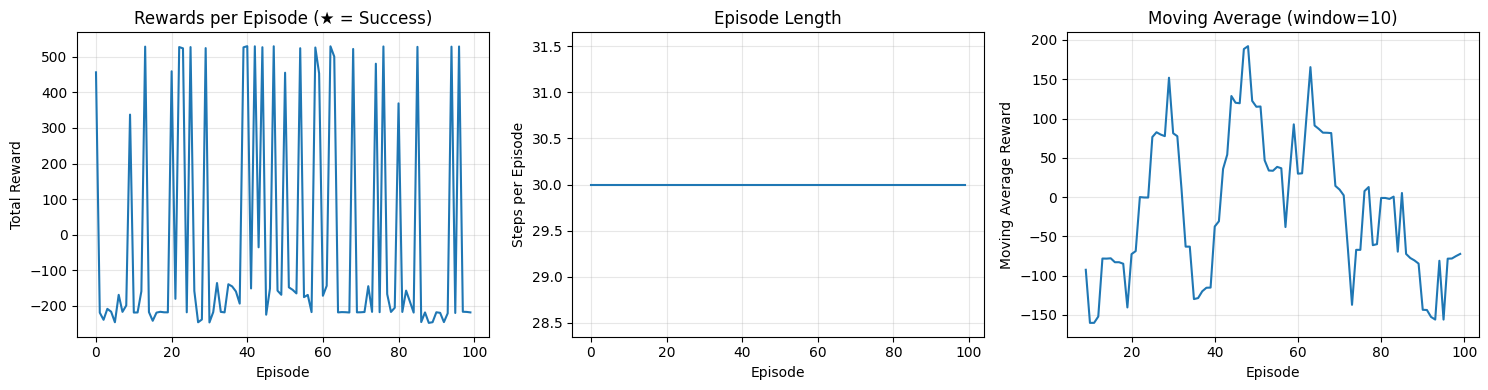


💾 Save these results to file? (y/n): y

❌ An error occurred: cannot access local variable 'rl_agent' where it is not associated with a value
Please restart the program.

PROGRAM COMPLETED


In [25]:
# ============================================================================
# REINFORCEMENT LEARNING AGENT FOR CHEMICAL COMPOUND EXPLORATION
# ============================================================================

import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')
import re

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

# Visualization
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# ============================================================================
# 1. DATA PREPARATION FOR RL AGENT
# ============================================================================

print("=" * 80)
print("REINFORCEMENT LEARNING AGENT FOR CHEMICAL COMPOUND EXPLORATION")
print("=" * 80)

# Load the dataset (using the previously loaded df)
print("\n📊 Preparing data for RL agent...")

# Remove DOI column if present
if 'DOI' in df.columns:
    df_rl = df.drop('DOI', axis=1)
    print("✅ Removed 'DOI' column")
else:
    df_rl = df.copy()

# Ensure we have the required columns
if 'Compound' not in df_rl.columns or 'Diameter' not in df_rl.columns:
    print("❌ Error: Dataset must contain 'Compound' and 'Diameter' columns")
    print(f"Available columns: {df_rl.columns.tolist()}")
else:
    print(f"✅ Dataset loaded: {df_rl.shape[0]} compounds, {df_rl.shape[1]} features")

    # Get unique compounds
    unique_compounds = df_rl['Compound'].unique()
    print(f"📊 Unique compounds in database: {len(unique_compounds)}")

    # Display some statistics
    print(f"\n📈 Diameter statistics:")
    print(f"  Min: {df_rl['Diameter'].min():.2f}")
    print(f"  Max: {df_rl['Diameter'].max():.2f}")
    print(f"  Mean: {df_rl['Diameter'].mean():.2f}")
    print(f"  Std: {df_rl['Diameter'].std():.2f}")

    # Show compound distribution
    compound_counts = df_rl['Compound'].value_counts()
    print(f"\n📊 Top 5 most frequent compounds:")
    for compound, count in compound_counts.head().items():
        print(f"  {compound}: {count} samples")

# ============================================================================
# 2. PREPARE MODELS FOR RL AGENT (CLASSIFICATION FIRST, REGRESSION SECOND)
# ============================================================================

print("\n" + "=" * 80)
print("TRAINING MODELS FOR RL AGENT")
print("=" * 80)

def prepare_rl_models(df_rl):
    """
    Prepare classification and regression models for the RL agent.
    Classification model predicts compound from features.
    Regression model predicts diameter from features (including compound).
    """

    # ============================================================================
    # 2.1 CLASSIFICATION MODEL: Predict Compound from Features
    # ============================================================================

    print("\n🔬 Training Classification Model (Compound Prediction)...")

    # Prepare data for classification
    X_clf = df_rl.drop(['Compound', 'Diameter'], axis=1)
    y_clf = df_rl['Compound']

    # Encode categorical features
    categorical_cols = X_clf.select_dtypes(include=['object', 'category']).columns
    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        X_clf[col] = le.fit_transform(X_clf[col].astype(str))
        label_encoders[col] = le

    # Encode target
    le_target = LabelEncoder()
    y_clf_encoded = le_target.fit_transform(y_clf)

    # Train classifier
    clf_model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        verbosity=0
    )

    clf_model.fit(X_clf, y_clf_encoded)

    # Test accuracy
    train_accuracy = clf_model.score(X_clf, y_clf_encoded)
    print(f"✅ Classification model trained - Train accuracy: {train_accuracy:.4f}")
    print(f"   Number of classes: {len(le_target.classes_)}")

    # ============================================================================
    # 2.2 REGRESSION MODEL: Predict Diameter from Features (including Compound)
    # ============================================================================

    print("\n📏 Training Regression Model (Diameter Prediction)...")

    # Prepare data for regression
    df_reg = df_rl.copy()

    # Encode compound for regression
    le_compound = LabelEncoder()
    df_reg['Compound_encoded'] = le_compound.fit_transform(df_reg['Compound'])

    # Prepare features and target
    X_reg = df_reg.drop('Diameter', axis=1)
    y_reg = df_reg['Diameter']

    # Remove the original compound column (use encoded version)
    if 'Compound' in X_reg.columns:
        X_reg = X_reg.drop('Compound', axis=1)

    # Encode remaining categorical features
    for col in X_reg.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X_reg[col] = le.fit_transform(X_reg[col].astype(str))
        label_encoders[col] = le

    # Train regressor
    reg_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        verbosity=0
    )

    reg_model.fit(X_reg, y_reg)

    # Test performance
    y_pred = reg_model.predict(X_reg)
    r2 = 1 - np.sum((y_reg - y_pred) ** 2) / np.sum((y_reg - np.mean(y_reg)) ** 2)
    rmse = np.sqrt(np.mean((y_reg - y_pred) ** 2))

    print(f"✅ Regression model trained - R²: {r2:.4f}, RMSE: {rmse:.4f}")

    # ============================================================================
    # 2.3 CREATE FEATURE SPACE FOR RL AGENT
    # ============================================================================

    print("\n🗺️ Creating feature space for RL agent...")

    # Get feature ranges for exploration
    feature_ranges = {}
    for col in X_clf.columns:
        if col in X_clf.select_dtypes(include=[np.number]).columns:
            min_val = X_clf[col].min()
            max_val = X_clf[col].max()
            feature_ranges[col] = (min_val, max_val)

    print(f"✅ Feature space created with {len(feature_ranges)} numerical features")

    return {
        'clf_model': clf_model,
        'reg_model': reg_model,
        'le_target': le_target,
        'le_compound': le_compound,
        'feature_ranges': feature_ranges,
        'original_features': X_clf.columns.tolist(),
        'compound_list': unique_compounds.tolist(),
        'diameter_range': (df_rl['Diameter'].min(), df_rl['Diameter'].max())
    }

# Train the models
rl_models = prepare_rl_models(df_rl)

# ============================================================================
# 3. Q-LEARNING RL AGENT IMPLEMENTATION
# ============================================================================

print("\n" + "=" * 80)
print("Q-LEARNING REINFORCEMENT LEARNING AGENT")
print("=" * 80)

class CompoundExplorationAgent:
    """RL agent for exploring chemical compound space to find target compounds/diameters."""

    def __init__(self, models, num_actions=10, learning_rate=0.1, discount_factor=0.9,
                 exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.01):

        self.models = models
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate

        # Initialize Q-table (state: compound index, action: feature modification)
        self.num_states = len(models['compound_list'])
        self.q_table = np.zeros((self.num_states, num_actions))

        # Action descriptions
        self.action_descriptions = [
            "Increase main feature 1",
            "Decrease main feature 1",
            "Increase main feature 2",
            "Decrease main feature 2",
            "Increase temperature parameter",
            "Decrease temperature parameter",
            "Increase pressure parameter",
            "Decrease pressure parameter",
            "Increase time parameter",
            "Decrease time parameter"
        ]

        # Track episode statistics
        self.episode_rewards = []
        self.episode_steps = []
        self.episode_best_actions = []  # Track best actions per episode
        self.successful_episodes = []    # Track episodes that found target compound

        # Parse compound formulas for element comparison
        self.compound_elements = self._parse_compound_elements(models['compound_list'])

        print(f"✅ RL Agent initialized with {self.num_states} states and {num_actions} actions")

    def _parse_compound_elements(self, compound_list):
        """Parse chemical formulas to extract elements."""
        compound_elements = {}
        for compound in compound_list:
            # Parse chemical formula (e.g., "CdSe", "ZnS", "PbTe")
            # This regex captures element symbols (one or two letters) followed optionally by numbers
            elements = re.findall(r'[A-Z][a-z]?\d*', compound)
            # Remove numbers to get just element symbols
            element_set = set()
            for elem in elements:
                # Remove numbers from the element (e.g., "Se2" -> "Se")
                element_symbol = re.sub(r'\d+', '', elem)
                element_set.add(element_symbol)
            compound_elements[compound] = element_set
        return compound_elements

    def _compare_compounds(self, pred_compound, target_compound):
        """
        Compare two compounds and return similarity metrics.
        Returns: (element_match_score, is_same_type, is_partial_match)
        """
        pred_elements = self.compound_elements.get(pred_compound, set())
        target_elements = self.compound_elements.get(target_compound, set())

        if not pred_elements or not target_elements:
            return 0.0, False, False

        # Calculate element overlap
        common_elements = pred_elements.intersection(target_elements)
        all_elements = pred_elements.union(target_elements)

        # Element match score (0-1)
        if len(all_elements) > 0:
            element_match_score = len(common_elements) / len(all_elements)
        else:
            element_match_score = 0.0

        # Check if compounds are same type (binary, ternary, etc.)
        is_same_type = len(pred_elements) == len(target_elements)

        # Check if it's a partial match (at least one element in common)
        is_partial_match = len(common_elements) > 0

        return element_match_score, is_same_type, is_partial_match

    def get_state_index(self, compound_name):
        """Convert compound name to state index."""
        if compound_name in self.models['compound_list']:
            return self.models['compound_list'].index(compound_name)
        else:
            return -1  # Invalid state

    def get_compound_name(self, state_index):
        """Convert state index to compound name."""
        if 0 <= state_index < len(self.models['compound_list']):
            return self.models['compound_list'][state_index]
        return "Unknown"

    def get_reward(self, predicted_compound, predicted_diameter,
                   target_compound, target_diameter, current_features=None):
        """
        Calculate reward based on how close we are to target.
        Higher reward for closer matches to both compound and diameter.
        STRONG penalties for wrong compounds - chemically different compounds won't work.
        """

        # ============================================================
        # 1. COMPOUND MATCH REWARD/STRONG PENALTY
        # ============================================================

        if predicted_compound == target_compound:
            # Perfect compound match - chemically correct
            compound_reward = 10.0  # Base reward for correct compound
            compound_penalty = 0.0
            match_type = "PERFECT"

        else:
            # Calculate compound similarity
            element_match_score, is_same_type, is_partial_match = self._compare_compounds(
                predicted_compound, target_compound
            )

            # Apply STRONG penalties based on element mismatch
            # Even partial matches get strong penalties because chemically they won't work
            if is_partial_match:
                if element_match_score >= 0.5:
                    # Partial match (e.g., CdS vs CdSe) - chemically similar but NOT the same
                    # Still gets strong penalty because it won't work chemically
                    compound_reward = 0.0  # No reward for wrong compound
                    compound_penalty = -7.0  # STRONG penalty for chemically similar but wrong
                    match_type = "PARTIAL_MATCH"
                else:
                    # Some elements match but not enough (e.g., ZnS vs CdS)
                    compound_reward = 0.0
                    compound_penalty = -8.0  # Very strong penalty
                    match_type = "WEAK_MATCH"
            else:
                # No elements in common (e.g., CdS vs PbTe) - completely different chemistry
                compound_reward = 0.0
                compound_penalty = -10.0  # Maximum penalty
                match_type = "NO_MATCH"

        # ============================================================
        # 2. DIAMETER REWARD (only meaningful if compound is correct)
        # ============================================================

        diameter_range = self.models['diameter_range'][1] - self.models['diameter_range'][0]
        if diameter_range > 0:
            diameter_error = abs(predicted_diameter - target_diameter)
            # Diameter reward is only meaningful if compound is correct
            if predicted_compound == target_compound:
                diameter_reward = 5.0 * (1.0 - min(diameter_error / diameter_range, 1.0))
            else:
                # Reduced diameter reward for wrong compounds
                diameter_reward = 2.0 * (1.0 - min(diameter_error / diameter_range, 1.0))
        else:
            if predicted_compound == target_compound:
                diameter_reward = 5.0 if abs(predicted_diameter - target_diameter) < 0.01 else 0.0
            else:
                diameter_reward = 0.0

        # ============================================================
        # 3. FEATURE STABILITY BONUS (encourages realistic parameters)
        # ============================================================

        stability_bonus = 0.0
        if current_features is not None:
            # Check if features are within reasonable ranges
            valid_features = 0
            for feature, (min_val, max_val) in self.models['feature_ranges'].items():
                if feature in current_features:
                    val = current_features[feature]
                    if min_val <= val <= max_val:
                        valid_features += 1

            stability_bonus = valid_features / len(self.models['feature_ranges']) * 1.0

        # ============================================================
        # 4. COMPOUND CORRECTNESS BONUS (additional bonus for correct compound)
        # ============================================================

        correctness_bonus = 2.0 if predicted_compound == target_compound else 0.0

        # ============================================================
        # 5. COMBINE ALL COMPONENTS
        # ============================================================

        total_reward = (
            compound_reward +
            compound_penalty +
            diameter_reward +
            stability_bonus +
            correctness_bonus
        )

        # Ensure reward is not too negative
        total_reward = max(total_reward, -15.0)

        return total_reward, {
            'compound_reward': compound_reward,
            'compound_penalty': compound_penalty,
            'diameter_reward': diameter_reward,
            'stability_bonus': stability_bonus,
            'correctness_bonus': correctness_bonus,
            'match_type': match_type,
            'element_match_score': element_match_score if predicted_compound != target_compound else 1.0
        }

    def modify_features(self, current_features, action):
        """Modify features based on the selected action."""
        modified_features = current_features.copy()

        # Get feature names for modification
        feature_names = list(self.models['feature_ranges'].keys())
        if len(feature_names) == 0:
            return modified_features

        # Track which action was taken for analysis
        action_taken = {
            'action_id': action,
            'action_name': self.action_descriptions[action],
            'modified_features': []
        }

        # Map action to feature modification
        if action == 0:  # Increase main feature 1
            if len(feature_names) > 0:
                feature = feature_names[0]
                min_val, max_val = self.models['feature_ranges'][feature]
                old_val = modified_features.get(feature, min_val)
                new_val = min(max_val, old_val + 0.1 * (max_val - min_val))
                modified_features[feature] = new_val
                action_taken['modified_features'].append((feature, old_val, new_val))

        elif action == 1:  # Decrease main feature 1
            if len(feature_names) > 0:
                feature = feature_names[0]
                min_val, max_val = self.models['feature_ranges'][feature]
                old_val = modified_features.get(feature, max_val)
                new_val = max(min_val, old_val - 0.1 * (max_val - min_val))
                modified_features[feature] = new_val
                action_taken['modified_features'].append((feature, old_val, new_val))

        elif action == 2:  # Increase main feature 2
            if len(feature_names) > 1:
                feature = feature_names[1]
                min_val, max_val = self.models['feature_ranges'][feature]
                old_val = modified_features.get(feature, min_val)
                new_val = min(max_val, old_val + 0.1 * (max_val - min_val))
                modified_features[feature] = new_val
                action_taken['modified_features'].append((feature, old_val, new_val))

        elif action == 3:  # Decrease main feature 2
            if len(feature_names) > 1:
                feature = feature_names[1]
                min_val, max_val = self.models['feature_ranges'][feature]
                old_val = modified_features.get(feature, max_val)
                new_val = max(min_val, old_val - 0.1 * (max_val - min_val))
                modified_features[feature] = new_val
                action_taken['modified_features'].append((feature, old_val, new_val))

        # For other actions, modify random features
        else:
            # Select a random feature to modify
            feature = random.choice(feature_names)
            min_val, max_val = self.models['feature_ranges'][feature]
            old_val = modified_features.get(feature, (min_val + max_val) / 2)

            if action % 2 == 0:  # Even actions: increase
                new_val = min(max_val, old_val + 0.05 * (max_val - min_val))
                modified_features[feature] = new_val
            else:  # Odd actions: decrease
                new_val = max(min_val, old_val - 0.05 * (max_val - min_val))
                modified_features[feature] = new_val

            action_taken['modified_features'].append((feature, old_val, new_val))

        return modified_features, action_taken

    def predict_from_features(self, features_dict):
        """Use trained models to predict compound and diameter from features."""

        # Convert features to dataframe
        features_df = pd.DataFrame([features_dict])

        # Ensure all expected features are present
        for feature in self.models['original_features']:
            if feature not in features_df.columns:
                # Use median value from training
                if feature in self.models['feature_ranges']:
                    min_val, max_val = self.models['feature_ranges'][feature]
                    features_df[feature] = (min_val + max_val) / 2

        # Reorder columns to match training
        features_df = features_df[self.models['original_features']]

        # Predict compound
        compound_proba = self.models['clf_model'].predict_proba(features_df)[0]
        compound_idx = np.argmax(compound_proba)
        predicted_compound = self.models['le_target'].classes_[compound_idx]
        confidence = compound_proba[compound_idx]

        # Prepare features for diameter prediction (include compound)
        reg_features = features_df.copy()

        # Add encoded compound
        if predicted_compound in self.models['le_compound'].classes_:
            compound_encoded = self.models['le_compound'].transform([predicted_compound])[0]
            reg_features['Compound_encoded'] = compound_encoded
        else:
            # Use most common compound if prediction is outside training
            reg_features['Compound_encoded'] = 0

        # Predict diameter
        predicted_diameter = self.models['reg_model'].predict(reg_features)[0]

        return predicted_compound, predicted_diameter, confidence

    def choose_action(self, state):
        """Choose action using epsilon-greedy policy."""
        if random.random() < self.exploration_rate:
            # Explore: random action
            return random.randint(0, self.num_actions - 1)
        else:
            # Exploit: best action from Q-table
            return np.argmax(self.q_table[state])

    def update_q_value(self, state, action, reward, next_state):
        """Update Q-value using Q-learning update rule."""
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

    def train_episode(self, target_compound, target_diameter, max_steps=50, verbose=True):
        """Train for one episode."""
        # Initialize state (start from a random compound in the database)
        if target_compound in self.models['compound_list']:
            start_compound = target_compound
        else:
            start_compound = random.choice(self.models['compound_list'])

        state = self.get_state_index(start_compound)

        # Initialize random features
        current_features = {}
        for feature, (min_val, max_val) in self.models['feature_ranges'].items():
            current_features[feature] = random.uniform(min_val, max_val)

        total_reward = 0
        steps = 0
        best_reward = -np.inf
        best_compound = start_compound
        best_diameter = 0
        best_features = current_features.copy()
        episode_actions = []  # Track all actions taken in this episode
        successful = False

        if verbose:
            print(f"\n🎯 Target: Compound='{target_compound}', Diameter={target_diameter:.2f}")
            print(f"🚀 Starting from: Compound='{start_compound}'")
            print("-" * 80)

        for step in range(max_steps):
            # Choose action
            action = self.choose_action(state)

            # Modify features based on action
            new_features, action_info = self.modify_features(current_features, action)
            action_info['step'] = step
            episode_actions.append(action_info)

            # Predict compound and diameter with new features
            predicted_compound, predicted_diameter, confidence = self.predict_from_features(new_features)

            # Get new state (based on predicted compound)
            next_state = self.get_state_index(predicted_compound)
            if next_state == -1:  # Invalid compound predicted
                next_state = state  # Stay in current state
                predicted_compound = self.get_compound_name(state)

            # Calculate reward
            reward, reward_breakdown = self.get_reward(
                predicted_compound, predicted_diameter,
                target_compound, target_diameter,
                new_features
            )

            # Update Q-table
            self.update_q_value(state, action, reward, next_state)

            # Update statistics
            total_reward += reward
            steps += 1

            # Track best result
            if reward > best_reward:
                best_reward = reward
                best_compound = predicted_compound
                best_diameter = predicted_diameter
                best_features = new_features.copy()
                best_step = step

            # Update current state and features
            state = next_state
            current_features = new_features

            # Display step information
            if verbose and step % 3 == 0:  # Show more frequently
                match_type = reward_breakdown['match_type']
                if match_type == "PERFECT":
                    match_symbol = "✅"
                elif match_type == "PARTIAL_MATCH":
                    match_symbol = "⚠️"
                else:
                    match_symbol = "❌"

                print(f"Step {step:3d}: {match_symbol} Action='{self.action_descriptions[action]}'")
                print(f"       Predicted: {match_symbol} '{predicted_compound}' ({confidence:.2%}), "
                      f"Diameter={predicted_diameter:.2f}")
                print(f"       Reward: {reward:6.2f} [C:{reward_breakdown['compound_reward']:+.1f}, "
                      f"P:{reward_breakdown['compound_penalty']:+.1f}, "
                      f"D:{reward_breakdown['diameter_reward']:+.1f}, "
                      f"S:{reward_breakdown['stability_bonus']:+.1f}]")
                print(f"       Match: {match_type}")
                if predicted_compound != target_compound and 'element_match_score' in reward_breakdown:
                    print(f"       Element similarity: {reward_breakdown['element_match_score']:.2%}")
                print("-" * 80)

            # Early stopping if we found a perfect match
            if predicted_compound == target_compound and abs(predicted_diameter - target_diameter) < 0.1:
                successful = True
                if verbose:
                    print(f"🎉 Perfect match found at step {step}!")
                break

        # Decay exploration rate
        self.exploration_rate = max(self.min_exploration_rate,
                                   self.exploration_rate * self.exploration_decay)

        # Store episode statistics
        self.episode_rewards.append(total_reward)
        self.episode_steps.append(steps)
        self.episode_best_actions.append({
            'best_reward': best_reward,
            'best_compound': best_compound,
            'best_diameter': best_diameter,
            'best_step': best_step if 'best_step' in locals() else steps-1,
            'successful': successful,
            'episode_actions': episode_actions
        })

        if successful:
            self.successful_episodes.append(len(self.episode_rewards) - 1)

        if verbose:
            print(f"\n📊 Episode Summary:")
            print(f"   Total steps: {steps}")
            print(f"   Total reward: {total_reward:.2f}")
            print(f"   Best found: Compound='{best_compound}', Diameter={best_diameter:.2f}")
            print(f"   Exploration rate: {self.exploration_rate:.3f}")
            print(f"   Success: {'✅ YES' if successful else '❌ NO'}")

        return best_compound, best_diameter, best_features, best_reward, successful, episode_actions

    def plot_training_progress(self):
        """Plot training progress."""
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Plot rewards
        axes[0].plot(self.episode_rewards)
        # Mark successful episodes
        for episode_idx in self.successful_episodes:
            if episode_idx < len(self.episode_rewards):
                axes[0].scatter(episode_idx, self.episode_rewards[episode_idx],
                              color='green', s=100, marker='*', zorder=5)
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Total Reward')
        axes[0].set_title('Rewards per Episode (★ = Success)')
        axes[0].grid(True, alpha=0.3)

        # Plot steps
        axes[1].plot(self.episode_steps)
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Steps per Episode')
        axes[1].set_title('Episode Length')
        axes[1].grid(True, alpha=0.3)

        # Plot moving average of rewards
        window_size = max(1, len(self.episode_rewards) // 10)
        if len(self.episode_rewards) >= window_size:
            moving_avg = np.convolve(self.episode_rewards,
                                    np.ones(window_size)/window_size,
                                    mode='valid')
            axes[2].plot(range(window_size-1, len(self.episode_rewards)), moving_avg)
            axes[2].set_xlabel('Episode')
            axes[2].set_ylabel('Moving Average Reward')
            axes[2].set_title(f'Moving Average (window={window_size})')
            axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def display_successful_agent_parameters(self, episode_idx=-1):
        """Display all parameters chosen by a successful agent in an episode."""
        if not self.successful_episodes:
            print("❌ No successful episodes yet!")
            return

        if episode_idx == -1:
            # Use the last successful episode
            episode_idx = self.successful_episodes[-1]

        if episode_idx >= len(self.episode_best_actions):
            print(f"❌ Episode {episode_idx} data not available!")
            return

        episode_data = self.episode_best_actions[episode_idx]

        if not episode_data['successful']:
            print(f"❌ Episode {episode_idx} was not successful!")
            return

        print(f"\n{'='*80}")
        print(f"SUCCESSFUL AGENT PARAMETERS - Episode {episode_idx + 1}")
        print(f"{'='*80}")
        print(f"🏆 Success at step {episode_data['best_step']}")
        print(f"✅ Found compound: {episode_data['best_compound']}")
        print(f"📏 Diameter: {episode_data['best_diameter']:.2f}")
        print(f"💰 Best reward: {episode_data['best_reward']:.2f}")
        print(f"\n📋 Actions taken to reach success:")
        print(f"{'-'*80}")

        # Display all actions taken in this episode
        for i, action_info in enumerate(episode_data['episode_actions'][:episode_data['best_step'] + 1]):
            step = action_info['step']
            action_name = action_info['action_name']
            modified_features = action_info['modified_features']

            print(f"Step {step:3d}: {action_name}")
            for feature, old_val, new_val in modified_features:
                change = new_val - old_val
                change_symbol = "↑" if change > 0 else "↓"
                print(f"       {feature}: {old_val:.4f} → {new_val:.4f} ({change_symbol}{abs(change):.4f})")

            if i < len(episode_data['episode_actions']) - 1:
                print(f"{'-'*40}")

# Initialize RL agent
print("\n🤖 Initializing Q-Learning Agent...")
rl_agent = CompoundExplorationAgent(
    models=rl_models,
    num_actions=10,
    learning_rate=0.1,
    discount_factor=0.9,
    exploration_rate=1.0,
    exploration_decay=0.98,
    min_exploration_rate=0.01
)

# ============================================================================
# 4. INTERACTIVE USER INTERFACE
# ============================================================================

print("\n" + "=" * 80)
print("INTERACTIVE COMPOUND EXPLORATION")
print("=" * 80)

def get_user_target():
    """Get target compound and diameter from user."""
    while True:
        print(f"\n📋 Available compounds ({len(rl_models['compound_list'])}):")
        # Show compounds in a readable format
        compounds = rl_models['compound_list']
        compounds_per_line = 5
        for i in range(0, min(20, len(compounds)), compounds_per_line):
            print("  " + ", ".join(compounds[i:i+compounds_per_line]))
        if len(compounds) > 20:
            print(f"  ... and {len(compounds) - 20} more")

        target_compound = input("\n🎯 Enter target compound name: ").strip()

        if target_compound in rl_models['compound_list']:
            break
        else:
            print(f"❌ Compound '{target_compound}' not found in database.")
            print("   Please choose from the available compounds.")

    while True:
        try:
            target_diameter = float(input("📏 Enter target diameter: "))

            # Check if diameter is within reasonable range
            min_d, max_d = rl_models['diameter_range']
            if min_d <= target_diameter <= max_d:
                break
            else:
                print(f"⚠️ Warning: Diameter {target_diameter:.2f} is outside typical range [{min_d:.2f}, {max_d:.2f}]")
                proceed = input("   Do you want to proceed anyway? (y/n): ").lower()
                if proceed == 'y':
                    break
        except ValueError:
            print("❌ Please enter a valid number for diameter.")

    return target_compound, target_diameter

def run_exploration_episodes(target_compound, target_diameter, num_episodes=20):
    """Run multiple exploration episodes."""
    print(f"\n{'='*80}")
    print(f"EXPLORING FOR: Compound='{target_compound}', Diameter={target_diameter:.2f}")
    print(f"Training for {num_episodes} episodes...")
    print(f"{'='*80}")

    best_overall_reward = -np.inf
    best_results = None
    successful_episodes = []

    for episode in range(num_episodes):
        print(f"\n📈 Episode {episode + 1}/{num_episodes}")

        # Add sleep for better visualization
        time.sleep(0.5)

        # Train for one episode
        verbose_mode = (episode % 5 == 0) or (episode == num_episodes - 1)
        best_compound, best_diameter, best_features, best_reward, successful, episode_actions = rl_agent.train_episode(
            target_compound=target_compound,
            target_diameter=target_diameter,
            max_steps=30,
            verbose=verbose_mode
        )

        # Track successful episodes
        if successful:
            successful_episodes.append(episode)
            print(f"   🎉 SUCCESS in episode {episode + 1}!")

        # Track best overall result
        if best_reward > best_overall_reward:
            best_overall_reward = best_reward
            best_results = {
                'compound': best_compound,
                'diameter': best_diameter,
                'features': best_features,
                'reward': best_reward,
                'episode': episode,
                'successful': successful
            }

        # Display non-verbose episode summary
        if not verbose_mode:
            # Compare compounds for penalty information
            element_match_score, _, _ = rl_agent._compare_compounds(best_compound, target_compound)
            if best_compound == target_compound:
                match_info = "✅ PERFECT"
            elif element_match_score > 0:
                match_info = f"⚠️ PARTIAL ({element_match_score:.0%} match)"
            else:
                match_info = "❌ NO MATCH"

            success_indicator = "🎉 " if successful else ""
            print(f"   {success_indicator}Best reward: {best_reward:.2f}, Found: {best_compound} {match_info}")

    # Display final results
    print(f"\n{'='*80}")
    print("EXPLORATION COMPLETE")
    print(f"{'='*80}")

    if best_results:
        print(f"\n🏆 BEST OVERALL RESULT:")
        print(f"   Episode: {best_results['episode'] + 1}")
        print(f"   Compound: {best_results['compound']}")
        print(f"   Diameter: {best_results['diameter']:.2f} (Target: {target_diameter:.2f})")
        print(f"   Reward: {best_results['reward']:.2f}")
        print(f"   Success: {'✅ YES' if best_results['successful'] else '❌ NO'}")

        # Calculate compound similarity
        element_match_score, is_same_type, is_partial_match = rl_agent._compare_compounds(
            best_results['compound'], target_compound
        )

        print(f"\n📊 Compound Analysis:")
        if best_results['compound'] == target_compound:
            print(f"   ✅ PERFECT MATCH: Correct compound")
        elif is_partial_match:
            print(f"   ⚠️ PARTIAL MATCH: {element_match_score:.0%} element similarity")
            print(f"      ⚠️ STRONG PENALTY APPLIED: Chemically different compounds won't work!")
        else:
            print(f"   ❌ NO MATCH: Completely different compounds")
            print(f"      ❌ MAXIMUM PENALTY APPLIED: Completely wrong chemistry!")

        # Calculate diameter error
        diameter_error = abs(best_results['diameter'] - target_diameter)
        print(f"\n📏 Diameter Analysis:")
        print(f"   Error: {diameter_error:.2f}")
        if diameter_error < 0.1:
            print(f"   ✅ Excellent diameter match!")
        elif diameter_error < 0.5:
            print(f"   ⚠️ Acceptable diameter match")
        else:
            print(f"   ❌ Poor diameter match")

        # Show successful episodes summary
        if successful_episodes:
            print(f"\n✅ SUCCESSFUL EPISODES: {len(successful_episodes)}/{num_episodes}")
            print(f"   Episodes: {[e+1 for e in successful_episodes]}")

            # Ask if user wants to see successful agent parameters
            if successful_episodes:
                view_params = input("\n🔍 View successful agent parameters from last episode? (y/n): ").lower()
                if view_params == 'y':
                    rl_agent.display_successful_agent_parameters()
        else:
            print(f"\n❌ NO SUCCESSFUL EPISODES")

        if best_results['compound'] == target_compound and diameter_error < 0.5:
            print(f"\n🎉 SUCCESS: Found close match to target!")
        else:
            print(f"\n🔍 CONTINUE: Try more episodes or adjust parameters")

    # Show training progress
    rl_agent.plot_training_progress()

    return best_results

def interactive_session():
    """Run interactive session with user."""
    print("\n👋 Welcome to the Chemical Compound Exploration Agent!")
    print("This RL agent will explore the chemical space to find compounds with specific properties.")
    print("\n📋 STRICT REWARD SYSTEM (Chemically Aware):")
    print("  ✅ Perfect compound match: +10.0 + diameter reward + stability + 2.0 bonus")
    print("  ⚠️ Partial match (e.g., CdS vs CdSe): -7.0 STRONG PENALTY (chemically won't work)")
    print("  ❌ No element match: -10.0 MAXIMUM PENALTY (completely wrong chemistry)")
    print("  📏 Diameter reward: up to +5.0 (reduced for wrong compounds)")
    print("  ⚖️ Feature stability: up to +1.0")

    session_active = True

    while session_active:
        print(f"\n{'='*80}")
        print("MAIN MENU")
        print(f"{'='*80}")
        print("1. Set new target and explore")
        print("2. View available compounds")
        print("3. View agent statistics")
        print("4. View successful agent parameters")
        print("5. Reset agent (clear learning)")
        print("6. Exit")

        choice = input("\nSelect option (1-6): ").strip()

        if choice == '1':
            # Get target from user
            target_compound, target_diameter = get_user_target()

            # Get number of episodes
            while True:
                try:
                    num_episodes = int(input("Number of exploration episodes (10-100): "))
                    if 10 <= num_episodes <= 100:
                        break
                    else:
                        print("Please enter a number between 10 and 100.")
                except ValueError:
                    print("Please enter a valid number.")

            # Run exploration
            results = run_exploration_episodes(target_compound, target_diameter, num_episodes)

            # Ask if user wants to save results
            if results:
                save = input("\n💾 Save these results to file? (y/n): ").lower()
                if save == 'y':
                    filename = f"exploration_results_{target_compound}_{target_diameter:.1f}.txt"
                    with open(filename, 'w') as f:
                        f.write(f"Target Compound: {target_compound}\n")
                        f.write(f"Target Diameter: {target_diameter:.2f}\n\n")
                        f.write(f"Best Found Compound: {results['compound']}\n")
                        f.write(f"Best Found Diameter: {results['diameter']:.2f}\n")
                        f.write(f"Reward: {results['reward']:.2f}\n")
                        f.write(f"Episode: {results['episode'] + 1}\n")
                        f.write(f"Success: {'YES' if results['successful'] else 'NO'}\n\n")

                        # Add compound analysis
                        element_match_score, _, _ = rl_agent._compare_compounds(results['compound'], target_compound)
                        f.write(f"Element Similarity: {element_match_score:.2%}\n\n")

                        f.write("Optimal Features:\n")
                        for feature, value in results['features'].items():
                            f.write(f"  {feature}: {value:.4f}\n")

                        # Add successful episodes info
                        if rl_agent.successful_episodes:
                            f.write(f"\nSuccessful Episodes: {len(rl_agent.successful_episodes)}\n")
                            f.write(f"Episodes: {[e+1 for e in rl_agent.successful_episodes]}\n")
                    print(f"✅ Results saved to {filename}")

        elif choice == '2':
            print(f"\n📋 Available Compounds ({len(rl_models['compound_list'])}):")
            compounds = rl_models['compound_list']
            compounds_per_line = 5
            for i in range(0, len(compounds), compounds_per_line):
                print("  " + ", ".join(compounds[i:i+compounds_per_line]))

        elif choice == '3':
            print(f"\n📊 Agent Statistics:")
            print(f"   Number of states: {rl_agent.num_states}")
            print(f"   Number of actions: {rl_agent.num_actions}")
            print(f"   Total episodes trained: {len(rl_agent.episode_rewards)}")
            print(f"   Successful episodes: {len(rl_agent.successful_episodes)}")

            if rl_agent.episode_rewards:
                print(f"\n📈 Reward Statistics:")
                print(f"   Average reward: {np.mean(rl_agent.episode_rewards):.2f}")
                print(f"   Best reward: {np.max(rl_agent.episode_rewards):.2f}")
                print(f"   Worst reward: {np.min(rl_agent.episode_rewards):.2f}")
                print(f"   Exploration rate: {rl_agent.exploration_rate:.3f}")

                # Show penalty statistics
                negative_rewards = [r for r in rl_agent.episode_rewards if r < 0]
                if negative_rewards:
                    print(f"\n⚖️ Penalty Statistics:")
                    print(f"   Episodes with penalties: {len(negative_rewards)}/{len(rl_agent.episode_rewards)}")
                    print(f"   Average penalty: {np.mean(negative_rewards):.2f}")
                    print(f"   Strongest penalty: {np.min(negative_rewards):.2f}")

            # Show Q-table statistics
            print(f"\n🧠 Q-Table Statistics:")
            print(f"   Mean Q-value: {np.mean(rl_agent.q_table):.4f}")
            print(f"   Max Q-value: {np.max(rl_agent.q_table):.4f}")
            print(f"   Min Q-value: {np.min(rl_agent.q_table):.4f}")

            # Show successful episodes details
            if rl_agent.successful_episodes:
                print(f"\n✅ Successful Episodes Details:")
                for idx, ep_idx in enumerate(rl_agent.successful_episodes[-3:]):  # Show last 3
                    if ep_idx < len(rl_agent.episode_best_actions):
                        ep_data = rl_agent.episode_best_actions[ep_idx]
                        print(f"   Episode {ep_idx + 1}: Reward={ep_data['best_reward']:.2f}, "
                              f"Compound={ep_data['best_compound']}, Diameter={ep_data['best_diameter']:.2f}")

        elif choice == '4':
            if not rl_agent.successful_episodes:
                print("❌ No successful episodes yet!")
            else:
                print(f"\n📊 Successful Episodes Available: {len(rl_agent.successful_episodes)}")
                print(f"   Latest: Episode {rl_agent.successful_episodes[-1] + 1}")

                if len(rl_agent.successful_episodes) > 1:
                    try:
                        ep_num = int(input(f"Enter episode number to view (1-{len(rl_agent.episode_rewards)}), "
                                          f"or 0 for latest: "))
                        if ep_num == 0:
                            episode_idx = rl_agent.successful_episodes[-1]
                        elif 1 <= ep_num <= len(rl_agent.episode_rewards):
                            episode_idx = ep_num - 1
                            if episode_idx not in rl_agent.successful_episodes:
                                print(f"⚠️ Episode {ep_num} was not successful!")
                                continue
                        else:
                            print("❌ Invalid episode number!")
                            continue
                    except ValueError:
                        print("❌ Please enter a valid number!")
                        continue
                else:
                    episode_idx = rl_agent.successful_episodes[-1]

                rl_agent.display_successful_agent_parameters(episode_idx)

        elif choice == '5':
            confirm = input("\n⚠️ Are you sure you want to reset the agent? All learning will be lost. (y/n): ").lower()
            if confirm == 'y':
                # Reinitialize agent
                rl_agent = CompoundExplorationAgent(
                    models=rl_models,
                    num_actions=10,
                    learning_rate=0.1,
                    discount_factor=0.9,
                    exploration_rate=1.0,
                    exploration_decay=0.98,
                    min_exploration_rate=0.01
                )
                print("✅ Agent reset successfully!")

        elif choice == '6':
            print("\n👋 Thank you for using the Chemical Compound Exploration Agent!")
            session_active = False

        else:
            print("❌ Invalid choice. Please select 1-6.")

# ============================================================================
# 5. RUN INTERACTIVE SESSION
# ============================================================================

# Start interactive session
try:
    interactive_session()
except KeyboardInterrupt:
    print("\n\n⚠️ Program interrupted by user.")
except Exception as e:
    print(f"\n❌ An error occurred: {str(e)}")
    print("Please restart the program.")

print("\n" + "=" * 80)
print("PROGRAM COMPLETED")
print("=" * 80)